# FCM-based Cognitive Multi-Agent Architecture for Safety-Oriented Organizational Simulation
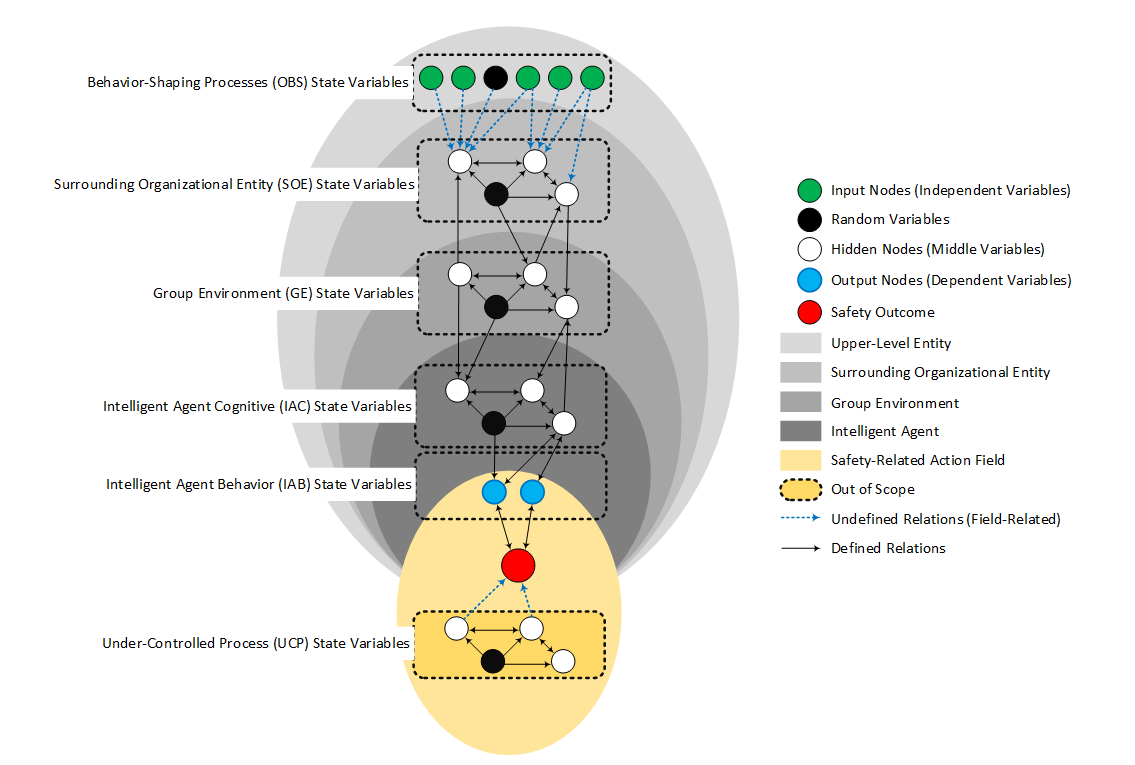

# Scenario-Based FCM Simulation

**Simulation Framework for Aggregated Safety Behavior Modeling**
To analyze the aggregated influence of organizational mechanisms on safety-related behavior under uncertainty, we developed a scenario-based simulation framework built upon a Fuzzy Cognitive Map (FCM) architecture. The model integrates expert-defined causal relationships and executes a time-stepped simulation to estimate emergent behavioral outcomes. To ensure robust interpretation of outputs despite the presence of random latent constructs, we incorporated Latin Hypercube Sampling (LHS) as a systematic method for uncertainty quantification.

The FCM structure is encoded as a weighted directed graph where nodes represent behavioral or contextual constructs (e.g., safety commitment, workload, or supervision) and edges denote their normalized causal influence. Behavioral state propagation is governed by a nonlinear transition function, specifically the hyperbolic tangent (tanh) scaled by an α-sensitivity factor, which allows bounded activation within [-1, 1] while preserving smooth gradients (Kosko, 1986; Papageorgiou & Salmeron, 2013).

To initialize the simulation, Behavior-Shaping Parameters (BSPs) are fuzzified using a 5-level linguistic scale ("Very Low" to "Very High") and incorporated directly into the root nodes. All random nodes, typically used to reflect uncontrollable contextual factors (e.g., external disruptions or individual variability), are treated as model inputs. Their values are generated using LHS across the interval [-1, 1], which ensures stratified coverage of the input space and avoids clustering, a limitation of naïve Monte Carlo methods (McKay et al., 1979).

Each simulation run proceeds through a fixed number of iterations (e.g., 15 time steps), allowing the system to reach a quasi-steady-state. For each LHS sample, the final behavioral output nodes are aggregated in two ways:

Fuzzy Aggregation: Membership values in {Low, Medium, High} are averaged across output nodes to yield a composite fuzzy vector per simulation. This reflects the system's final behavioral state in fuzzy terms.

Defuzzified Aggregation: Crisp values from each output node (obtained via weighted average defuzzification) are averaged to derive a single system-level numeric index per run.

Following the simulation of all LHS samples (with automatic sample size determined based on the number of random input dimensions), results are summarized statistically. The final defuzzified system-level index is characterized by its mean, standard deviation, and a 90% confidence interval (5th–95th percentiles). This enables both descriptive interpretation and robustness analysis of the safety behavior model under epistemic uncertainty.

Such a hybrid fuzzy–probabilistic simulation approach supports both qualitative and quantitative reasoning, offering practical insight into the expected behavior of socio-technical systems under complex organizational influences (Zio, 2018; Kabir & Papageorgiou, 2019).

📚 References (APA Format)
Kabir, S., & Papageorgiou, E. I. (2019). A review of applications of fuzzy cognitive maps for decision support systems. Knowledge-Based Systems, 145, 34–60. https://doi.org/10.1016/j.knosys.2018.05.009

Kosko, B. (1986). Fuzzy cognitive maps. International Journal of Man-Machine Studies, 24(1), 65–75. https://doi.org/10.1016/S0020-7373(86)80040-2

McKay, M. D., Beckman, R. J., & Conover, W. J. (1979). A comparison of three methods for selecting values of input variables in the analysis of output from a computer code. Technometrics, 21(2), 239–245. https://doi.org/10.1080/00401706.1979.10489755

Papageorgiou, E. I., & Salmeron, J. L. (2013). A review of fuzzy cognitive maps research during the last decade. IEEE Transactions on Fuzzy Systems, 21(1), 66–79. https://doi.org/10.1109/TFUZZ.2012.2201727

Zio, E. (2018). The future of risk assessment. Reliability Engineering & System Safety, 177, 176–190. https://doi.org/10.1016/j.ress.2018.04.020

# Pseudocode: Fuzzy Cognitive Map Simulation with LHS Sampling

Input:
    - GraphML file representing the FCM (nodes, edges, weights)
    - Excel file of BSP input values (linguistic or numeric)

Output:
    - Aggregated fuzzy output (Low, Medium, High)
    - Defuzzified numeric index with uncertainty analysis
    - Visualizations and summary statistics

----------------------------------------------------------

1. Load Model Structure
    - Import FCM graph from GraphML file
    - Create normalized adjacency matrix W from edge weights

2. Prepare BSP Inputs
    - Read BSP values from Excel
    - Fuzzify using 5-level triangular membership
    - Assign to root input nodes

3. Identify Node Types
    - Random nodes: name contains "random"
    - Output nodes: labeled as behavioral outcomes
    - Root nodes: nodes with in-degree zero (BSPs + randoms)

4. Generate LHS Samples
    - Determine sample size based on number of random inputs
    - Create LHS matrix over [-1, 1] for random input nodes

5. For each LHS sample:
    a. Initialize Node States
        - BSPs ← fuzzified values
        - Randoms ← values from current LHS sample
        - Others ← randomly initialized crisp values

    b. For T iterations:
        For each node i:
            If i in root_nodes or random_nodes:
                - Skip update, retain value
            Else:
                - Compute weighted sum: s_i = Σ w_ji * a_j
                - Normalize: s_i' = s_i / Σ |w_ji|
                - Activation: a_i = tanh(α * s_i')
                - If output node → fuzzify a_i
                - Else → store as crisp float

    c. Extract Outputs
        - For each output node:
            - Store fuzzy membership (Low, Medium, High)
            - Defuzzify to numeric score
        - Compute system-level average

6. After All Samples:
    - Compute mean fuzzy output (L/M/H)
    - Compute mean, std, min, max, CI of defuzzified scores

7. Visualize:
    - Fuzzy stacked bar
    - Defuzzified score with 90% CI

8. Return:
    - Fuzzy output vector
    - List of defuzzified scores
    - Table of uncertainty metrics


In [ ]:
!pip install pyDOE

In [ ]:
# ==============================================
# FCM Simulation with LHS Sampling (Fully Annotated)
# ==============================================
# Author: ChatGPT | Use: Safety Behavior Modeling (Aggregated Outputs)
# This script:
# - Loads a GraphML file representing an FCM
# - Loads BSP inputs from Excel
# - Identifies random input nodes
# - Applies Latin Hypercube Sampling (LHS) on those nodes
# - Runs the FCM simulation for each LHS sample
# - Aggregates fuzzy and defuzzified results across all output nodes
# - Visualizes final fuzzy and numeric summaries
# - Provides a table of uncertainty metrics

# --------------------------
# 📦 Import Required Libraries
# --------------------------
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyDOE import lhs
import unicodedata
import re

# --------------------------
# 🔧 Preprocessing Functions
# --------------------------
def clean_node_name(name):
    """
    Normalize and clean node names for reliable matching.
    """
    name = str(name).strip().lower()
    name = unicodedata.normalize("NFKD", name)
    name = re.sub(r'[\u200b-\u200f\u202a-\u202e\u00a0]', '', name)
    return name

def fuzzify_bsp_input(value):
    """
    Convert a crisp or linguistic BSP input to a 5-level fuzzy vector.
    """
    if isinstance(value, str):
        value = value.strip().lower()
        mapping = {
            "very low": [1, 0, 0, 0, 0],
            "low":      [0, 1, 0, 0, 0],
            "medium":   [0, 0, 1, 0, 0],
            "high":     [0, 0, 0, 1, 0],
            "very high":[0, 0, 0, 0, 1]
        }
        return mapping.get(value, [0, 0, 1, 0, 0])
    else:
        x = float(value)
        return [
            max(0, 1 - 4 * x),
            max(0, 1 - abs(4 * x - 1)),
            max(0, 1 - abs(4 * x - 2)),
            max(0, 1 - abs(4 * x - 3)),
            max(0, 4 * x - 3) if x >= 0.75 else 0
        ]

def triangular_membership(x, a, b, c):
    """
    Calculate membership value of x in a triangular fuzzy set.
    """
    if x < a or x > c: return 0.0
    elif x == b: return 1.0
    elif x < b: return (x - a) / (b - a)
    else: return (c - x) / (c - b)

def fuzzify_output(x):
    """
    Convert a crisp value to a 3-level fuzzy output.
    """
    return {
        'Low': triangular_membership(x, -1, -1, 0),
        'Medium': triangular_membership(x, -1, 0, 1),
        'High': triangular_membership(x, 0, 1, 1)
    }

def defuzzify(fuzzy_vector):
    """
    Convert a fuzzy vector (Low/Medium/High or Very Low/.../Very High) to a crisp value.
    """
    mapping_3 = {'Low': -1, 'Medium': 0, 'High': 1}
    mapping_5 = {'Very Low': -1, 'Low': -0.5, 'Medium': 0, 'High': 0.5, 'Very High': 1}

    labels = set(fuzzy_vector.keys())
    if labels <= set(mapping_3.keys()):
        mapping = mapping_3
    elif labels <= set(mapping_5.keys()):
        mapping = mapping_5
    else:
        raise ValueError(f"Unrecognized fuzzy labels: {labels}")

    numerator = sum(mapping[k] * v for k, v in fuzzy_vector.items())
    denominator = sum(fuzzy_vector.values())
    return numerator / denominator if denominator != 0 else 0

# --------------------------
# 📊 FCM Structure and Initialization
# --------------------------
def graph_to_fcm(g, weight_property="weight", normalize=True):
    """
    Convert a NetworkX graph to an adjacency matrix.
    """
    nodes = list(g.nodes())
    idx = {n: i for i, n in enumerate(nodes)}
    W = np.zeros((len(nodes), len(nodes)))
    for u, v, d in g.edges(data=True):
        w = float(d.get(weight_property, 1))
        W[idx[u], idx[v]] = (w / 5.0) if normalize else w
    return W

def initialize_fcm_state_fuzzy_final(graph, bsp_inputs):
    """
    Initialize FCM node states, identifying random, root, and output nodes.
    """
    init_state = {}
    rand_nodes, root_nodes, out_nodes = [], [], []
    for i, (node, data) in enumerate(graph.nodes(data=True)):
        name = clean_node_name(data.get("name", str(node)))
        label = clean_node_name(data.get("label", str(node)))
        is_random = "random" in name
        is_behavior = re.search(r"_behavior_\d+$", label or "")
        is_bsp = name in bsp_inputs
        is_root = graph.in_degree(node) == 0
        if is_random:
            init_state[i] = np.random.uniform(-1, 1)
            rand_nodes.append(i)
        elif is_bsp:
            vec = bsp_inputs[name]
            init_state[i] = {k: float(v) for k, v in zip(["Very Low", "Low", "Medium", "High", "Very High"], vec)}
        elif is_behavior:
            out_nodes.append(i)
            init_state[i] = fuzzify_output(np.random.uniform(-1, 1))
        else:
            init_state[i] = np.random.uniform(-1, 1)
        if is_root: root_nodes.append(i)
    return init_state, rand_nodes, root_nodes, out_nodes

# --------------------------
# 🔁 Core FCM Simulation
# --------------------------
def nonlinear_transition(wsum, wtot, alpha=1.5):
    return np.tanh(alpha * wsum / wtot) if wtot != 0 else 0.0

def fcm_simulation(W, init_state, root_nodes, rand_nodes, out_nodes, n_iter=10):
    """
    Run one FCM simulation over time steps.
    """
    S = init_state.copy()
    for _ in range(n_iter):
        S_next = {}
        for i in range(W.shape[0]):
            if i in root_nodes or i in rand_nodes:
                S_next[i] = S[i]
                continue
            wsum, wtot = 0, 0
            for j in range(W.shape[0]):
                w = W[j, i]
                if w == 0: continue
                x = defuzzify(S[j]) if isinstance(S[j], dict) else S[j]
                wsum += w * x
                wtot += abs(w)
            res = nonlinear_transition(wsum, wtot)
            S_next[i] = fuzzify_output(res) if i in out_nodes else res
        S = S_next
    return S

# --------------------------
# 📈 LHS Sampling and Aggregation
# --------------------------
def determine_lhs_sample_size(n_rand):
    """Determine number of LHS samples based on random node count."""
    if n_rand <= 5: return 100
    elif n_rand <= 10: return 200
    elif n_rand <= 20: return 300
    else: return 500

def run_lhs_simulation(graph, W, bsp_inputs, rand_nodes, root_nodes, out_nodes, n_iter=10):
    d = len(rand_nodes)
    n_samples = determine_lhs_sample_size(d)
    lhs_samples = lhs(d, samples=n_samples) * 2 - 1
    fuzzy_agg_list = []
    defuzz_agg_list = []
    for s in lhs_samples:
        init_state, _, _, _ = initialize_fcm_state_fuzzy_final(graph, bsp_inputs)
        for idx, val in zip(rand_nodes, s):
            init_state[idx] = val
        final = fcm_simulation(W, init_state, root_nodes, rand_nodes, out_nodes, n_iter=n_iter)
        # Fuzzy aggregation
        fuzzy_vals = [final[i] for i in out_nodes]
        agg = {'Low': 0, 'Medium': 0, 'High': 0}
        for f in fuzzy_vals:
            for k in agg:
                agg[k] += f.get(k, 0)
        for k in agg:
            agg[k] /= len(fuzzy_vals)
        fuzzy_agg_list.append(agg)
        # Defuzzified aggregation
        defuzz_vals = [defuzzify(final[i]) for i in out_nodes]
        defuzz_agg_list.append(np.mean(defuzz_vals))
    return fuzzy_agg_list, defuzz_agg_list

# --------------------------
# 📊 Visualization & Summary
# --------------------------
def plot_fuzzy_bar(fuzzy_agg_mean):
    plt.figure(figsize=(6, 1.2))
    colors = ['red', 'orange', 'green']
    levels = ['Low', 'Medium', 'High']
    start = 0
    for lvl, color in zip(levels, colors):
        width = fuzzy_agg_mean[lvl]
        plt.barh(0, width, left=start, color=color, edgecolor='black')
        start += width
    plt.xlim(0, 1)
    plt.yticks([])
    plt.title("Fuzzy Aggregated Output")
    plt.show()

def plot_defuzzified_bar_normalized(defuzz_results):
    """
    Visualize defuzzified outputs mapped to [0,1] for visual consistency with fuzzy outputs.
    """
    # Map defuzzified results from [-1,1] → [0,1]
    norm_results = [(x + 1) / 2 for x in defuzz_results]
    mean = np.mean(norm_results)
    low = np.percentile(norm_results, 5)
    high = np.percentile(norm_results, 95)

    plt.figure(figsize=(6, 1.2))
    plt.barh(0, 1, left=0, color='lightgray', edgecolor='black')  # background bar
    plt.plot(mean, 0, 'ko', label='Mean')
    plt.errorbar(mean, 0, xerr=[[mean - low], [high - mean]], fmt='o', color='black', capsize=5)

    plt.xlim(0, 1)
    plt.yticks([])
    plt.xlabel("Defuzzified score (rescaled to 0–1)")
    plt.title("Normalized Defuzzified Output with 90% CI")
    plt.tight_layout()
    plt.show()

def summarize_defuzzified(defuzz_results):
    """
    Generate a summary table with uncertainty metrics and definitions.
    """
    summary = {
        "Mean": np.mean(defuzz_results),
        "Std Dev": np.std(defuzz_results),
        "Min": np.min(defuzz_results),
        "Max": np.max(defuzz_results),
        "5th Percentile": np.percentile(defuzz_results, 5),
        "95th Percentile": np.percentile(defuzz_results, 95),
        "95% CI Width": np.percentile(defuzz_results, 95) - np.percentile(defuzz_results, 5)
    }
    definitions = {
        "Mean": "Average system-level behavior score.",
        "Std Dev": "Standard deviation indicating variation across samples.",
        "Min": "Lowest observed output in the simulations.",
        "Max": "Highest observed output in the simulations.",
        "5th Percentile": "Lower bound of 90% confidence interval.",
        "95th Percentile": "Upper bound of 90% confidence interval.",
        "95% CI Width": "Spread of the 90% confidence range (sensitivity width)."
    }
    df = pd.DataFrame.from_dict(summary, orient='index', columns=["Value"])
    df["Definition"] = df.index.map(definitions)
    return df


# --------------------------
# 🧠 Final Simulation Function
# --------------------------
def run_full_simulation(graph_file, excel_file):
    G = nx.read_graphml(graph_file)
    df = pd.read_excel(excel_file)
    df.columns = df.columns.str.strip().str.lower()
    bsp_inputs = {clean_node_name(row['name']): fuzzify_bsp_input(row['value']) for _, row in df.iterrows()}
    W = graph_to_fcm(G)
    init_state, rand_nodes, root_nodes, out_nodes = initialize_fcm_state_fuzzy_final(G, bsp_inputs)
    fuzzy_results, defuzz_results = run_lhs_simulation(G, W, bsp_inputs, rand_nodes, root_nodes, out_nodes)
    fuzzy_avg = {
        'Low': np.mean([f['Low'] for f in fuzzy_results]),
        'Medium': np.mean([f['Medium'] for f in fuzzy_results]),
        'High': np.mean([f['High'] for f in fuzzy_results])
    }
    plot_fuzzy_bar(fuzzy_avg)
    plot_defuzzified_bar_normalized(defuzz_results)
    summary_df = summarize_defuzzified(defuzz_results)
    return fuzzy_avg, defuzz_results, summary_df


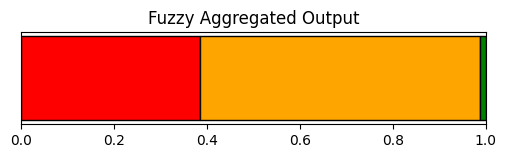

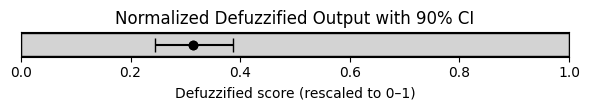

,Value,Definition
Mean,-0.373151,Average system-level behavior score.
Std Dev,0.086183,Standard deviation indicating variation across...
Min,-0.617978,Lowest observed output in the simulations.
Max,-0.113482,Highest observed output in the simulations.
5th Percentile,-0.511835,Lower bound of 90% confidence interval.
95th Percentile,-0.227092,Upper bound of 90% confidence interval.
95% CI Width,0.284743,Spread of the 90% confidence range (sensitivit...


In [ ]:
fuzzy_output, defuzz_values, summary_table = run_full_simulation("all_network.graphml", "fcm_input_template.xlsx")
summary_table
